XGBoost model for predicting filtered shear stress and Time to next event (TTF). 

(Multioutput Regression) 

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import statistics
from sklearn import multioutput
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import h5py

In [ ]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')

m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel(), 'TTF':data['TTF'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel()})  
df1 = a_t.merge(m_t, on='Time')

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_run1_pp_wAmp.mat')
df2 = pd.DataFrame({'maxFreqI_filt':data2['maxFreqI_filt'][3787:136186].ravel(), 'freqQAmpI_filt':data2['freqQAmpI_filt'][3787:136186].ravel(),
                    'freqQAmpI_filt_pc':data2['freqQAmpI_filt_pc'].ravel()})

df = pd.concat([df1, df2], axis=1)

print("Input data:\n", df.shape)

xdf = df.drop(['SS', 'TTF', 'Time'], axis=1)
ydf = df[['SS', 'TTF']]

print("Features:\n", xdf)
print("Shear stress:\n", ydf)

Input data:
 (132399, 8)
Features:
              V_filt  Vel_pc  maxFreqI_filt  freqQAmpI_filt  freqQAmpI_filt_pc
0       5489.978529     0.0  457680.400524    31438.277060                0.0
1       5489.981454     0.0  457727.638932    31421.341616                0.0
2       5489.997639     0.0  457770.778724    31409.798761                0.0
3       5490.007016     0.0  457811.889181    31398.815589                0.0
4       5490.000189     0.0  457775.514596    31395.584981                0.0
...             ...     ...            ...             ...                ...
132394  5459.380488     0.0  454414.128118    31041.955345                0.0
132395  5459.377762     0.0  454404.028108    31035.059531                0.0
132396  5459.388352     0.0  454403.709700    31020.001291                0.0
132397  5459.398820     0.0  454398.871858    31012.016780                0.0
132398  5459.399041     0.0  454410.333590    31010.874482                0.0

[132399 rows x 5 columns]
S

In [ ]:
# Split into train-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.3, shuffle=False)   
print("Training:", np.shape(x_train))
print("Testing:", np.shape(x_test))


Training: (92679, 5)
Testing: (39720, 5)


In [ ]:
# Train the model
model = XGBRegressor(colsample_bytree=1, learning_rate=0.1, max_depth=4, n_estimators=200, base_score=0.5, objective='reg:squarederror')
model = multioutput.MultiOutputRegressor(model)
model.fit(x_train, y_train)


MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=4, min_child_weight=1,
                                            missing=None, n_estimators=200,
                                            n_jobs=1, nthread=None,
                                            objective='reg:squarederror',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            

In [ ]:
# Evaluate the model

## Training
y_predTrain = pd.DataFrame(model.predict(x_train))
y_predTrain[1] = np.clip(y_predTrain[1], a_min=0, a_max=None)

ss_train_r2 = r2_score(y_train['SS'], y_predTrain[0])
ss_train_rmse = np.sqrt(mean_squared_error(y_train['SS'], y_predTrain[0]))

ttf_train_r2 = r2_score(y_train['TTF'], y_predTrain[1])
ttf_train_rmse = np.sqrt(mean_squared_error(y_train['TTF'], y_predTrain[1]))

## Testing
y_predTest = pd.DataFrame(model.predict(x_test))
y_predTest[1] = np.clip(y_predTest[1], a_min=0, a_max=None)

ss_test_r2 = r2_score(y_test['SS'], y_predTest[0])
ss_test_rmse = np.sqrt(mean_squared_error(y_test['SS'], y_predTest[0]))

ttf_test_r2 = r2_score(y_test['TTF'], y_predTest[1])
ttf_test_rmse = np.sqrt(mean_squared_error(y_test['TTF'], y_predTest[1]))


print('Shear Stress')
print('R2 score:', ss_train_r2, ss_test_r2, '\nRMSE:', ss_train_rmse, ss_test_rmse)
print('\nTTF')
print('R2 score:', ttf_train_r2, ttf_test_r2, '\nRMSE:', ttf_train_rmse, ttf_test_rmse)


Shear Stress
R2 score: 0.9146161047532834 0.8650132317785151 
RMSE: 0.03731277172600469 0.05348599520941947

TTF
R2 score: 0.885533911682881 0.7753113379234708 
RMSE: 0.3537533501933796 0.5443548324491968


In [ ]:
# Save the predictions

hf = h5py.File('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/predictions/xgb_mo.h5', 'w')
g1 = hf.create_group('ss')
g1.create_dataset('y_predTrain', data=y_predTrain[0])
g1.create_dataset('y_predTest', data=y_predTest[0])

g2 = hf.create_group('ttf')
g2.create_dataset('y_predTrain', data=y_predTrain[1])
g2.create_dataset('y_predTest', data=y_predTest[1])
hf.close()


Text(0.5, 1.0, 'Error plot for Time to Failure prediction using multioutput XGBoost model')

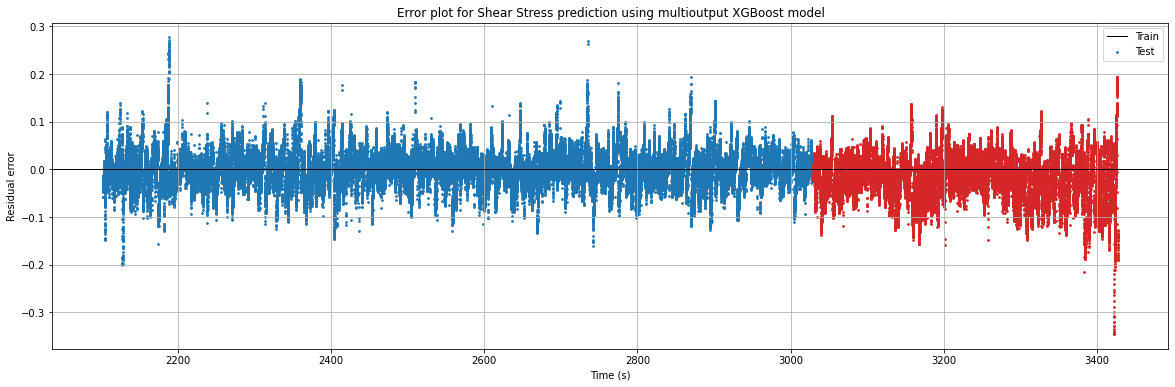

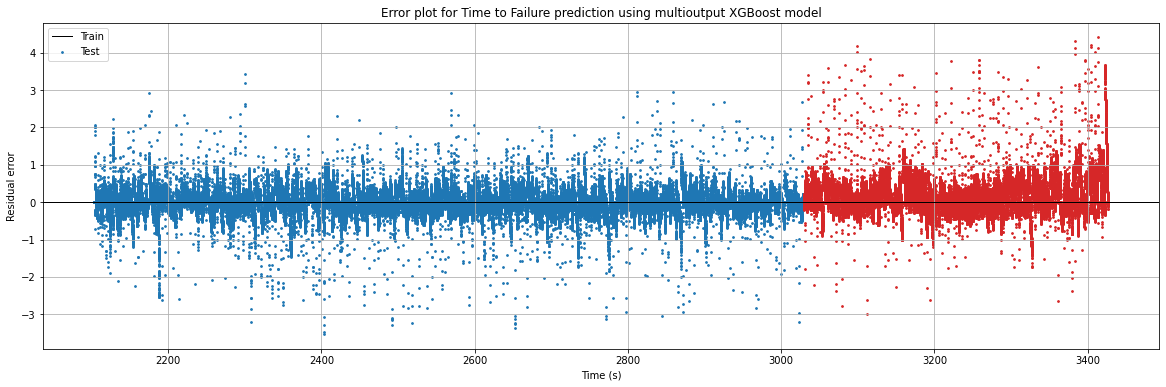

In [ ]:
# Residual plot

ttime = df1['Time']
traintime, testtime = train_test_split(ttime, test_size=0.3, shuffle=False)

Rtrain = y_train['SS'] - y_predTrain[0]
Rtest = y_test['SS'].values - y_predTest[0].values

fig = plt.figure(1, figsize=(20,6))
plt.scatter(traintime, Rtrain, s=3)
plt.scatter(testtime, Rtest, c='tab:red', s=3)
plt.xlabel('Time (s)')
plt.ylabel('Residual error')
plt.grid()
plt.axhline(linewidth=1, color='black')
plt.legend(['Train', 'Test'])
plt.title('Error plot for Shear Stress prediction using multioutput XGBoost model')

Rtrain = y_train['TTF'] - y_predTrain[1]
Rtest = y_test['TTF'].values - y_predTest[1].values

fig = plt.figure(2, figsize=(20,6))
plt.scatter(traintime, Rtrain, s=3)
plt.scatter(testtime, Rtest, c='tab:red', s=3)
plt.xlabel('Time (s)')
plt.ylabel('Residual error')
plt.grid()
plt.axhline(linewidth=1, color='black')
plt.legend(['Train', 'Test'])
plt.title('Error plot for Time to Failure prediction using multioutput XGBoost model')


Text(0.5, 1.0, 'Time to Failure prediction using multioutput XGBoost model')

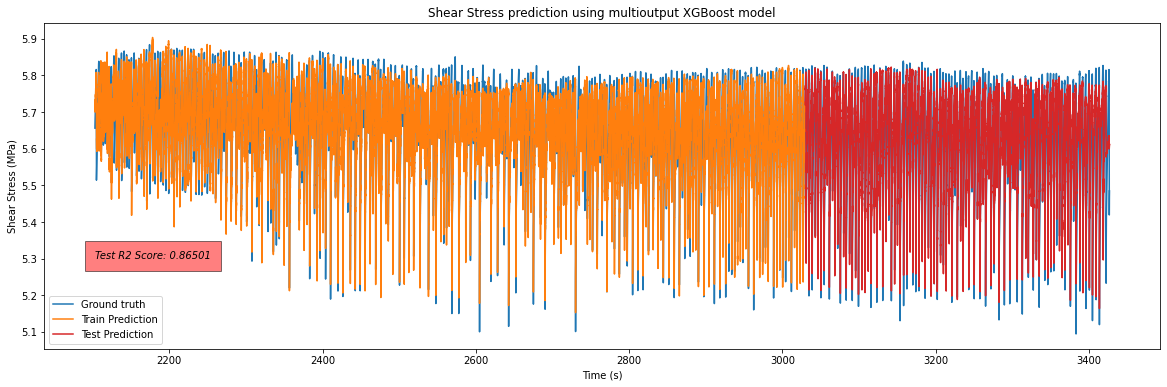

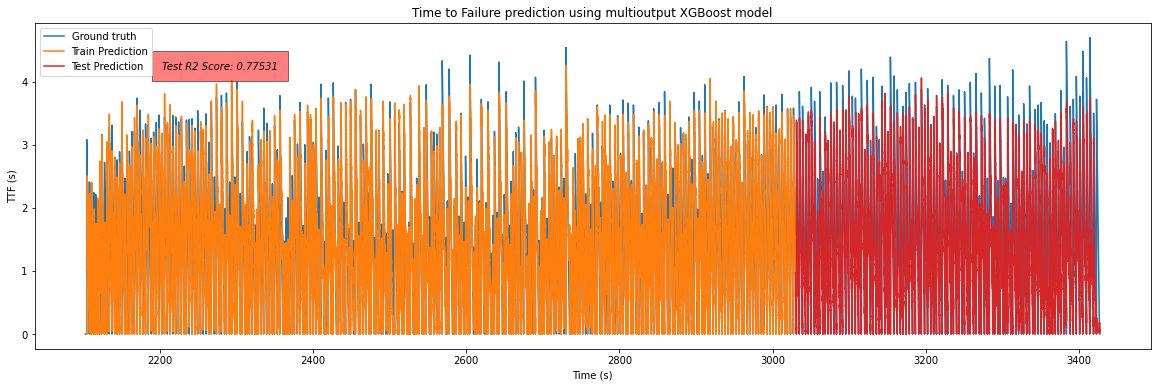

In [ ]:
# Overall plot

ttime = df1['Time']
traintime, testtime = train_test_split(ttime, test_size=0.3, shuffle=False)

## SS plot
fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf['SS'])
plt.plot(traintime, y_predTrain[0])
plt.plot(testtime, y_predTest[0], 'tab:red')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.text(ttime.iloc[0], 5.3, 'Test R2 Score: %0.5f' %(ss_test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
plt.legend(['Ground truth', 'Train Prediction', 'Test Prediction'])
plt.title('Shear Stress prediction using multioutput XGBoost model')

## TTF plot
fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf['TTF'])
plt.plot(traintime, y_predTrain[1])
plt.plot(testtime, y_predTest[1], 'tab:red')
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.text(ttime.iloc[10000], 4.2, 'Test R2 Score: %0.5f' %(ttf_test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
plt.legend(['Ground truth', 'Train Prediction', 'Test Prediction'])
plt.title('Time to Failure prediction using multioutput XGBoost model')



Text(0.5, 1.0, 'Detailed View, Testing Data')

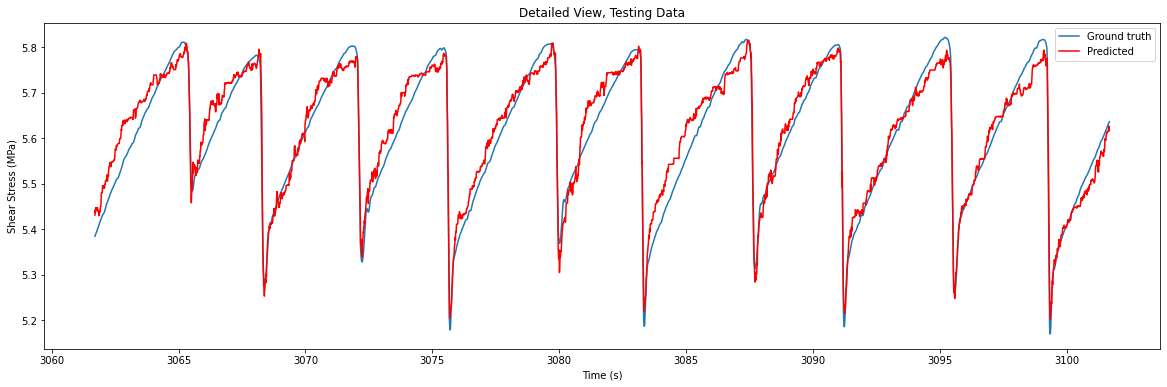

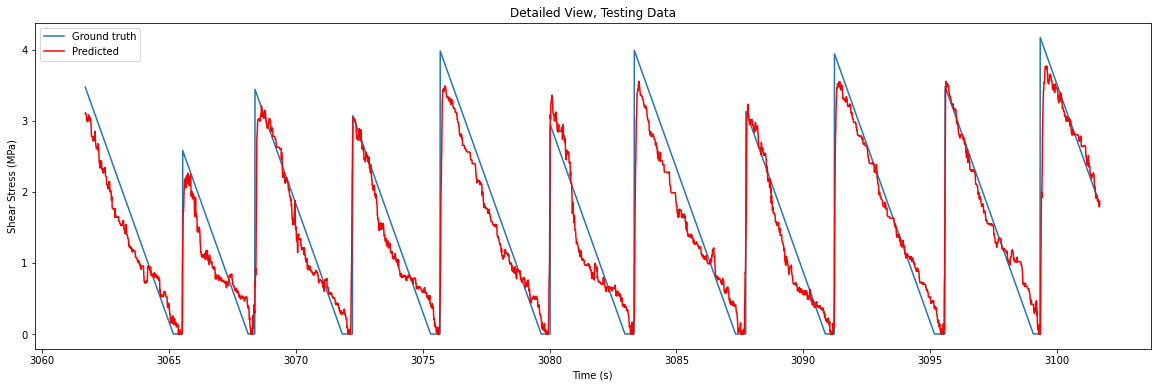

In [ ]:
# Detailed plot (test data)

n = 4000
st_i = 3200

## SS
fig = plt.figure(6, figsize=(20,6))
plt.plot(testtime[st_i:st_i+n], y_test['SS'][st_i:st_i+n])
plt.plot(testtime[st_i:st_i+n], y_predTest[0][st_i:st_i+n], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')

## TTF
fig = plt.figure(7, figsize=(20,6))
plt.plot(testtime[st_i:st_i+n], y_test['TTF'][st_i:st_i+n])
plt.plot(testtime[st_i:st_i+n], y_predTest[1][st_i:st_i+n], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')